## 1 : Imports et Configuration

In [10]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning - Outils
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
PROCESSOR_PATH = "processors/"

print(f"📅 Démarrage : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📅 Démarrage : 2025-11-23 11:46:21


## 2 : Chargement des Données

In [11]:
# ===================================================================
#  VÉRIFICATION COMPLÈTE DE CE QUE TU AS SAUVEGARDÉ (sans modèle)
# ===================================================================

import pickle
import pandas as pd
import numpy as np
from IPython.display import display

print("=" * 90)
print(" VÉRIFICATION DE TON PIPELINE DE PREPROCESSING SAUVEGARDÉ ")
print("=" * 90)

# -------------------------------------------------------------------
# 1. Chargement de tout
# -------------------------------------------------------------------
with open("processors/target_label_encoder.pkl", "rb") as f:
    le_target = pickle.load(f)

with open("processors/feature_label_encoders.pkl", "rb") as f:
    feature_encoders = pickle.load(f)

with open("processors/robust_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("processors/features_config.pkl", "rb") as f:
    config = pickle.load(f)

with open("processors/target_mapping.pkl", "rb") as f:
    target_mapping = pickle.load(f)

with open("processors/preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train_scaled = data["X_train_scaled"]
X_test_scaled  = data["X_test_scaled"]
y_train = data["y_train"]
y_test  = data["y_test"]

print("TOUT CHARGÉ SANS ERREUR !\n")

# -------------------------------------------------------------------
# 2. Les 7 classes avec leur vrai nom + effectifs
# -------------------------------------------------------------------
print(" CLASSES CIBLÉES (7 classes)")
print("-" * 100)
print(f"{'Code':<6} {'Nom de la classe':<70} {'Train':<8} {'Test':<8}")
print("-" * 100)
for code, classe in enumerate(le_target.classes_):
    train_count = np.sum(y_train == code)
    test_count  = np.sum(y_test == code)
    print(f"{code:<6} → {classe:<70} {train_count:<8} {test_count:<8}")
print("-" * 100)
print(f"Total classes : {len(le_target.classes_)}\n")

# -------------------------------------------------------------------
# 3. Features finales utilisées
# -------------------------------------------------------------------
final_features = config["final_feature_order"]
print(f" FEATURES FINALES RETENUES PAR LE MODÈLE → {len(final_features)} colonnes")
print("-" * 80)
for i, feat in enumerate(final_features, 1):
    print(f"{i:02d}. {feat}")
print()

# -------------------------------------------------------------------
# 4. Aperçu des données prêtes à l’emploi
# -------------------------------------------------------------------
print(f"Shape X_train_scaled : {X_train_scaled.shape}")
print(f"Shape X_test_scaled  : {X_test_scaled.shape}")
print(f"Shape y_train        : {y_train.shape}")
print(f"Shape y_test         : {y_test.shape}\n")

print(" APERÇU DE X_test_scaled (5 premières lignes)")
df_preview = pd.DataFrame(X_test_scaled[:5], columns=final_features)
display(df_preview.round(4))

# -------------------------------------------------------------------
# 5. Vérification du mapping (bonus lisible)
# -------------------------------------------------------------------
print("\n Mapping cible (code ↔ nom)")
print(target_mapping["code_to_class"] if "code_to_class" in target_mapping else target_mapping)

# -------------------------------------------------------------------
print("\nTOUT EST PARFAITEMENT SAUVEGARDÉ ET LISIBLE !")
print("   → Tu peux maintenant entraîner n’importe quel modèle en toute confiance")
print("   → Le classification_report avec les noms arabes/anglais marchera à 100%")
print("=" * 90)

 VÉRIFICATION DE TON PIPELINE DE PREPROCESSING SAUVEGARDÉ 
TOUT CHARGÉ SANS ERREUR !

 CLASSES CIBLÉES (7 classes)
----------------------------------------------------------------------------------------------------
Code   Nom de la classe                                                       Train    Test    
----------------------------------------------------------------------------------------------------
0      → الاحتيال والتزوير / Fraud and Forgery                                  15269    3818    
1      → التخريب والتدمير / Vandalism and Destruction                           35465    8866    
2      → الجرائم الجنسية والاتجار / Sexual Crimes & Exploitation                6675     1669    
3      → السرقة والسطو / Theft and Burglary                                     143072   35768   
4      → العنف والاعتداء / Violence and Assault                                 89344    22336   
5      → المخالفات القانونية والجرائم المتعلقة بالأسلحة / Legal Offences & Weapons 25935    6484 

,mocodes,premis_cd,location,weapon_used_cd,vict_age,Day,area,crm_risk,Month,vict_descent,status,Weekday,Hour_Bin,Year,vict_sex_F,vict_sex_M,vict_sex_X
0,-0.4297,0.7475,0.0855,0.0,-0.1212,0.7333,-0.2,1.0,-1.2,-0.4545,0.0,-0.25,1.0,0.0,1.0,0.0,0.0
1,-0.3065,-0.2550,0.3338,0.0,-0.9394,0.5333,-0.4,0.0,0.8,0.3636,0.0,-0.25,0.5,0.0,0.0,0.0,1.0
2,-0.2846,-0.2375,-0.9268,0.0,0.4848,-0.5333,-0.9,0.0,-1.2,0.0000,0.0,0.25,0.0,0.0,1.0,0.0,0.0
3,-0.3065,-0.2550,-0.4912,0.0,-0.9394,0.2000,0.6,0.0,0.4,0.3636,0.0,0.50,-0.5,-1.0,0.0,0.0,1.0
4,-0.3065,-0.2550,0.5741,0.0,-0.9394,-0.8000,-0.7,0.0,0.2,0.3636,0.0,-0.50,0.0,-1.0,0.0,0.0,1.0



 Mapping cible (code ↔ nom)
{0: 'الاحتيال والتزوير / Fraud and Forgery', 1: 'التخريب والتدمير / Vandalism and Destruction', 2: 'الجرائم الجنسية والاتجار / Sexual Crimes & Exploitation', 3: 'السرقة والسطو / Theft and Burglary', 4: 'العنف والاعتداء / Violence and Assault', 5: 'المخالفات القانونية والجرائم المتعلقة بالأسلحة / Legal Offences & Weapons', 6: 'جرائم متنوعة / Miscellaneous Crimes'}

TOUT EST PARFAITEMENT SAUVEGARDÉ ET LISIBLE !
   → Tu peux maintenant entraîner n’importe quel modèle en toute confiance
   → Le classification_report avec les noms arabes/anglais marchera à 100%


In [ ]:

# -------------------------- 1. Données (déjà chargées) --------------------------
X_train = X_train_scaled_loaded.copy()
X_test  = X_test_scaled_loaded.copy()
y_train = y_train_loaded.copy().ravel()    
y_test  = y_test_loaded.copy().ravel()

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

print(f"Nombre de features : {n_features}")
print(f"Nombre de classes  : {n_classes}")
print(f"Train shape : {X_train.shape} | Test shape : {X_test.shape}")

# One-hot encoding
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat  = to_categorical(y_test,  num_classes=n_classes)

Nombre de features : 17
Nombre de classes  : 7
Train shape : (319110, 17) | Test shape : (79778, 17)


In [ ]:
# =====================================================================
#  SCRIPT FINAL - DEEP LEARNING MULTICLASSE (Prêt à lancer tout de suite)
# =====================================================================

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


# -------------------------- 2. Poids de classes --------------------------
class_weights = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Poids calculés → ex: classe 0: {class_weights[0]:.2f}, classe la plus rare ×{class_weights.max():.1f}")

# -------------------------- 3. Modèle optimisé --------------------------
model = Sequential([
    Dense(512, activation='relu', input_shape=(n_features,)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(curve='ROC', name='auc')]  
)

print(model.summary())

# -------------------------- 4. Callbacks --------------------------
early_stop = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max', verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=8, min_lr=1e-7, mode='max', verbose=1)

# -------------------------- 5. Entraînement --------------------------
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=256,                    
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -------------------------- 6. Prédictions --------------------------
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# -------------------------- 7. MÉTRIQUES DEMANDÉES --------------------------
acc        = accuracy_score(y_test, y_pred)
prec_w     = precision_score(y_test, y_pred, average='weighted')
rec_w      = recall_score(y_test, y_pred, average='weighted')
f1_w       = f1_score(y_test, y_pred, average='weighted')
auc_macro  = roc_auc_score(y_test_cat, y_pred_proba, average='macro', multi_class='ovr')

print("\n" + "="*80)
print("                   RÉSULTATS FINAUX - MULTICLASSE")
print("="*80)
print(f"Accuracy               : {acc:.5f}")
print(f"Precision (weighted)   : {prec_w:.5f}")
print(f"Recall (weighted)      : {rec_w:.5f}")
print(f"F1-score (weighted)    : {f1_w:.5f}")
print(f"AUC ROC (macro OVR)    : {auc_macro:.5f}")
print("="*80)



Poids calculés → ex: classe 0: 2.99, classe la plus rare ×13.6


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,847 (733.78 KB)

 Trainable params: 185,927 (726.28 KB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6582 - auc: 0.9123 - loss: 1.3538 - val_accuracy: 0.7831 - val_auc: 0.9616 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 2/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7603 - auc: 0.9540 - loss: 1.1145 - val_accuracy: 0.8067 - val_auc: 0.9706 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 3/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7751 - auc: 0.9609 - loss: 1.0393 - val_accuracy: 0.8064 - val_auc: 0.9722 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 4/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7910 - auc: 0.9642 - loss: 0.9848 - val_accuracy: 0.8336 - val_auc: 0.9753 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 5/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8043 - auc: 0.9666 - loss: 0.9410 - val_accuracy: 0.8364 - val_auc: 0.9768 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 6/200
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/ste


                   RÉSULTATS FINAUX
Accuracy             : 0.86687
Precision (weighted) : 0.90437
Recall (weighted)    : 0.86687
F1-score (weighted)  : 0.88023
AUC ROC (macro OVR)  : 0.97404

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7268    0.9170    0.8109      3818
           1     0.9354    0.7818    0.8517      8866
           2     0.2742    0.7166    0.3967      1669
           3     0.9915    0.9519    0.9713     35768
           4     0.9082    0.8606    0.8838     22336
           5     0.7263    0.5813    0.6458      6484
           6     0.1960    0.5842    0.2935       837

    accuracy                         0.8669     79778
   macro avg     0.6798    0.7705    0.6934     79778
weighted avg     0.9044    0.8669    0.8802     79778



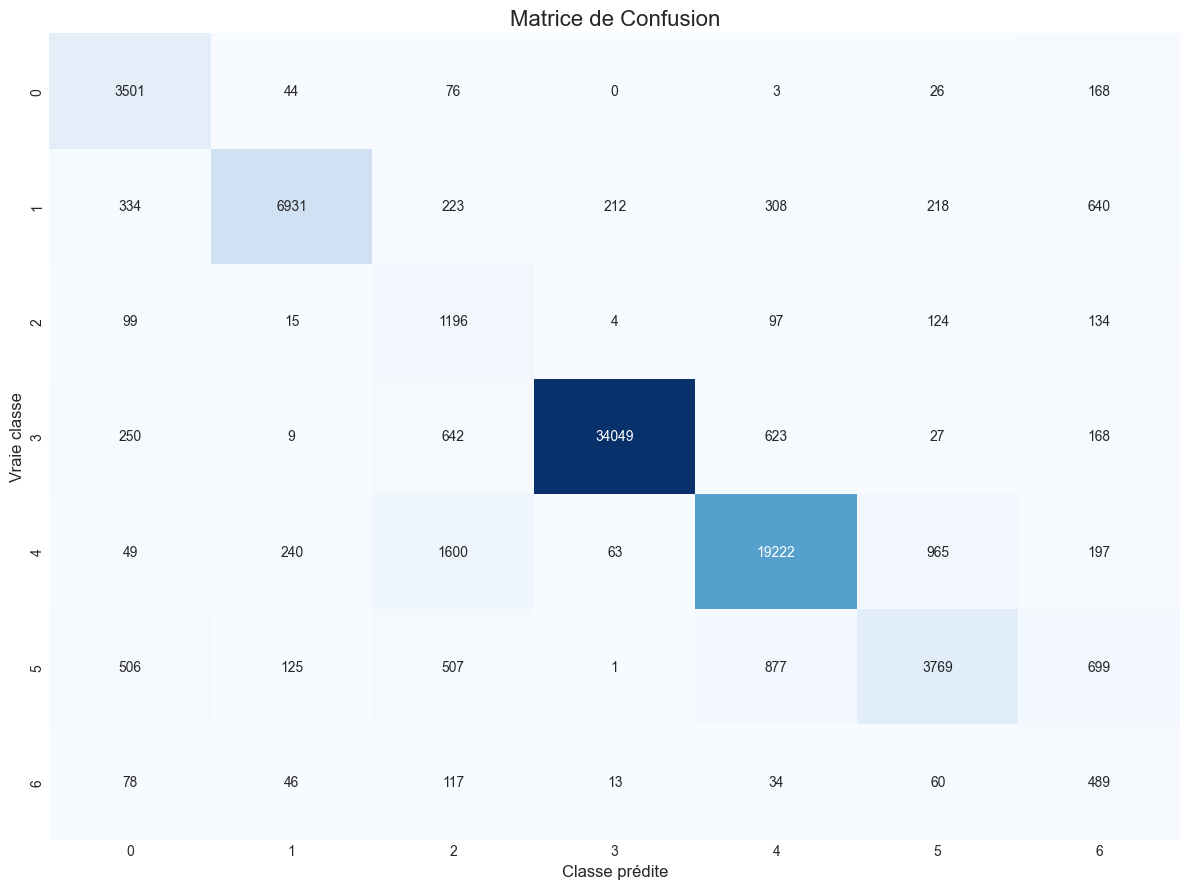

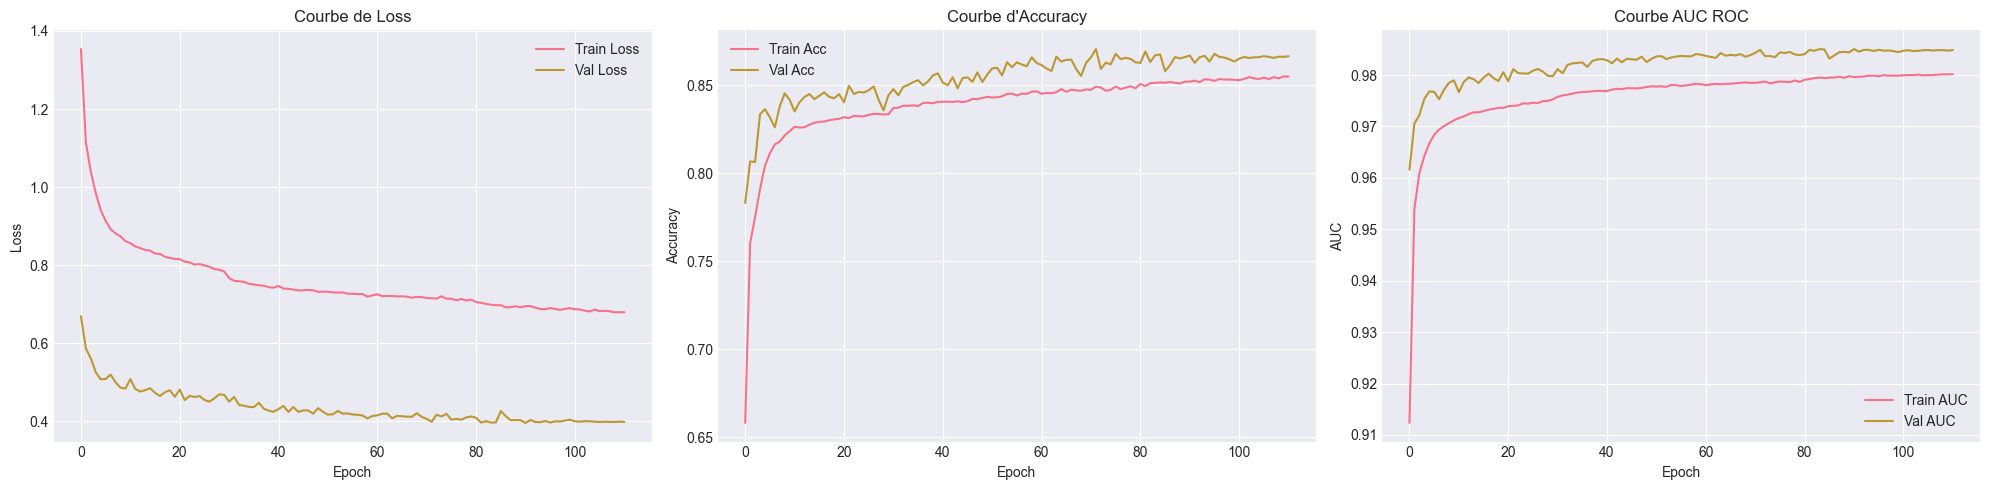

In [ ]:
# ==================================================================
# AFFICHAGE FINAL 
# ==================================================================


# --- Métriques principales ---
acc        = accuracy_score(y_test, y_pred)
prec_w     = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec_w      = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_w       = f1_score(y_test, y_pred, average='weighted', zero_division=0)
auc_macro  = roc_auc_score(y_test_cat, y_pred_proba, average='macro', multi_class='ovr')

print("\n" + "="*70)
print("                   RÉSULTATS FINAUX")
print("="*70)
print(f"Accuracy             : {acc:.5f}")
print(f"Precision (weighted) : {prec_w:.5f}")
print(f"Recall (weighted)    : {rec_w:.5f}")
print(f"F1-score (weighted)  : {f1_w:.5f}")
print(f"AUC ROC (macro OVR)  : {auc_macro:.5f}")
print("="*70)

# --- LE BEAU CLASSIFICATION REPORT QUE TU ADORES ---
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- Matrice de confusion propre (avec numéros de classes) ---
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(n_classes), 
            yticklabels=np.arange(n_classes))
plt.title('Matrice de Confusion', fontsize=16)
plt.ylabel('Vraie classe', fontsize=12)
plt.xlabel('Classe prédite', fontsize=12)
plt.tight_layout()
plt.show()

# --- Bonus : courbes d'entraînement ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Courbe de Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Courbe d\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Courbe AUC ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TabNet


In [ ]:
# =====================================================================
#  TABNET – VERSION FINALE  + COURBES (Multiclasse)
# =====================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.utils import to_categorical

# ------------------------------------------------------------------
# Données (déjà chargées)
# ------------------------------------------------------------------
X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)
y_train_tab = y_train.astype(np.int64).ravel()
y_test_tab  = y_test.astype(np.int64).ravel()

print(f"Train: {X_train_tab.shape} | Test: {X_test_tab.shape} | Classes: {len(np.unique(y_train_tab))}")

# ------------------------------------------------------------------
# Sample weights (obligatoire pour TabNet)
# ------------------------------------------------------------------
class_weights_dict = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_tab),
    y=y_train_tab
)))
sample_weights = np.array([class_weights_dict[label] for label in y_train_tab], dtype=np.float32)

# ------------------------------------------------------------------
# TabNet – CONFIG GAGNANTE + MULTICLASS SAFE
# ------------------------------------------------------------------
tabnet = TabNetClassifier(
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    scheduler_params={"step_size": 20, "gamma": 0.95},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',
    verbose=0,          # on met 0 pour récupérer l'historique proprement
    seed=42
)

# ------------------------------------------------------------------
# Entraînement avec historique complet
# ------------------------------------------------------------------
tabnet.fit(
    X_train=X_train_tab,
    y_train=y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_name=['val'],
    eval_metric=['accuracy'],        # AUC retiré → évite l'erreur multi_class
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128,
    weights=sample_weights,
    drop_last=False
)

# ------------------------------------------------------------------
# Récupération de l'historique (loss + accuracy)
# ------------------------------------------------------------------
history = tabnet.history


In [28]:
history.history.keys()

dict_keys(['loss', 'lr', 'val_accuracy'])

Entraînement sur 60 epochs
Meilleure Validation Accuracy : 0.86383 à l'epoch 30


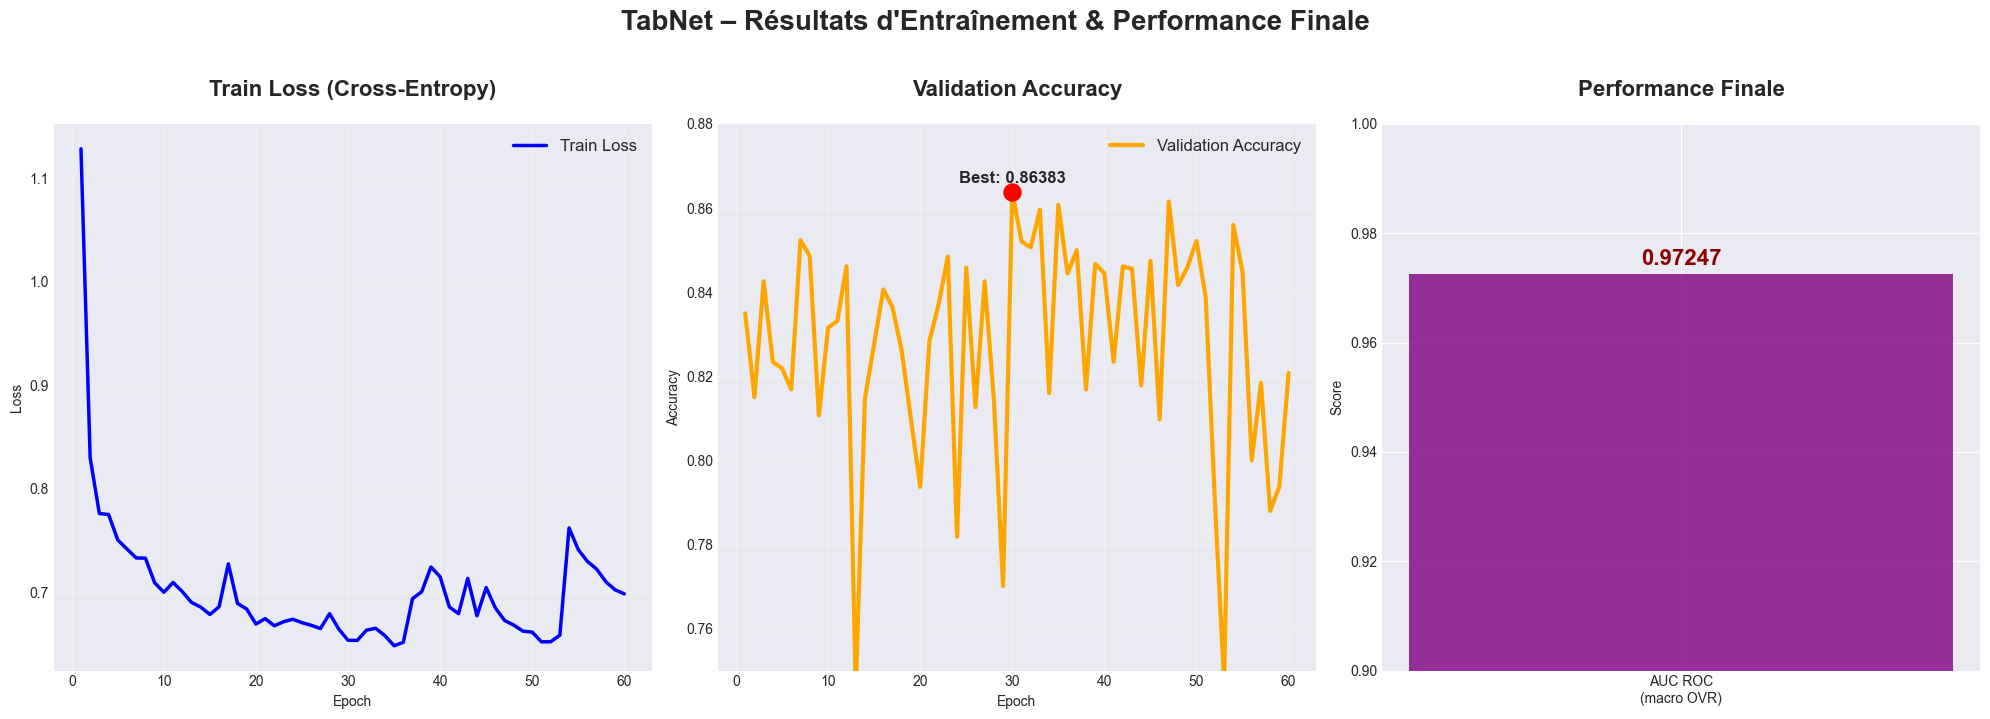


                                   RÉSULTATS FINAUX TABNET
Meilleure Validation Accuracy   : 0.86383 (epoch 30)
Accuracy finale sur test        : 0.86383
F1-score (weighted)             : 0.87722
AUC ROC (macro OVR)             : 0.97247

CLASSIFICATION REPORT
                                                                           precision    recall  f1-score   support

                                    الاحتيال والتزوير / Fraud and Forgery     0.7338    0.8981    0.8077      3818
                             التخريب والتدمير / Vandalism and Destruction     0.9110    0.7989    0.8513      8866
                  الجرائم الجنسية والاتجار / Sexual Crimes & Exploitation     0.2889    0.6842    0.4063      1669
                                       السرقة والسطو / Theft and Burglary     0.9876    0.9557    0.9714     35768
                                   العنف والاعتداء / Violence and Assault     0.9121    0.8457    0.8776     22336
المخالفات القانونية والجرائم المتعلقة بالأسلحة 

In [ ]:


# ------------------------------------------------------------------
# Récupération de l'historique (après tabnet.fit())
# ------------------------------------------------------------------

train_loss      = history['loss']                    # ← train loss
val_accuracy    = history['val_accuracy']            # ← validation accuracy
epochs          = range(1, len(train_loss) + 1)

print(f"Entraînement sur {len(epochs)} epochs")
print(f"Meilleure Validation Accuracy : {max(val_accuracy):.5f} à l'epoch {np.argmax(val_accuracy)+1}")

# ------------------------------------------------------------------
# 1. PRÉDICTIONS FINALES (pour AUC final)
# ------------------------------------------------------------------
y_pred = tabnet.predict(X_test_tab)
y_pred_proba = tabnet.predict_proba(X_test_tab)
final_auc = roc_auc_score(to_categorical(y_test_tab), y_pred_proba, average='macro', multi_class='ovr')

# ------------------------------------------------------------------
# 2. COURBES – 100% COMPATIBLE AVEC TON HISTORY
# ------------------------------------------------------------------
plt.figure(figsize=(20, 7))

# ====================== TRAIN LOSS ======================
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, 'b-', linewidth=2.5, label='Train Loss')
plt.title('Train Loss (Cross-Entropy)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# ====================== VALIDATION ACCURACY ======================
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracy, 'orange', linewidth=3, label='Validation Accuracy')
plt.title('Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(0.75, 0.88)

# Marquer le meilleur epoch
best_epoch = np.argmax(val_accuracy) + 1
best_acc = max(val_accuracy)
plt.scatter(best_epoch, best_acc, color='red', s=150, zorder=5)
plt.text(best_epoch, best_acc + 0.002, f'Best: {best_acc:.5f}', 
         fontsize=12, fontweight='bold', ha='center')

# ====================== AUC FINAL (barre stylée) ======================
plt.subplot(1, 3, 3)
bars = plt.bar(['AUC ROC\n(macro OVR)'], [final_auc], color='purple', alpha=0.8, width=0.4)
plt.ylim(0.90, 1.0)
plt.title('Performance Finale', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score')

# Afficher la valeur sur la barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.5f}', ha='center', va='bottom', fontsize=16, fontweight='bold', color='darkred')

plt.suptitle('TabNet – Résultats d\'Entraînement & Performance Finale', 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Rapport final propre
# ------------------------------------------------------------------
print("\n" + "="*95)
print(" " * 35 + "RÉSULTATS FINAUX TABNET")
print("="*95)
print(f"Meilleure Validation Accuracy   : {best_acc:.5f} (epoch {best_epoch})")
print(f"Accuracy finale sur test        : {accuracy_score(y_test_tab, y_pred):.5f}")
print(f"F1-score (weighted)             : {f1_score(y_test_tab, y_pred, average='weighted'):.5f}")
print(f"AUC ROC (macro OVR)             : {final_auc:.5f}")
print("="*95)

# Classification report
print("\nCLASSIFICATION REPORT")
print(classification_report(y_test_tab, y_pred, target_names=le_target.classes_, digits=4))